# Exercise 9: series

* pandas series vs numpy arrays [explanation](https://jakevdp.github.io/PythonDataScienceHandbook/03.01-introducing-pandas-objects.html)

### Common series operations
These are the most common series operations we use. Refer to the `pandas` docs for even more!

* Getting dates, hours, minutes from datetime types (`df.datetime_col.dt.date`)
* Parsing strings (`df.string_col.str.split('_')`)

### Common geoseries operations
These are the most common. Refer to the `geopandas` docs for even more!

* `distance` between 2 points or a point to a polygon or line [docs](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.distance.html)
* `intersects`: [docs](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.intersects.html)
* `within`: [docs](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.within.html)
* `contains`: [docs](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.contains.html)

In fact, we've often used geoseries methods without even realizing it. Often, we'd create a new column that stores either the line's length or a polygon's area. `gdf.geometry` is a geoseries, and we call methods on that geoseries, and add that as a new column.

For calculations like `length`, `area`, and `distance`, we need to use a projected CRS that has units like meters or feet. We cannot use decimal degrees (do not use WGS 84 / EPSG:3326)! Distance calculations must be done only once the spherical 3D Earth has been converted into a 2D plane.

* `length`: get the length of a line (`gdf.geometry.length`)
* `area`: get the area of a polygon (`gdf.geometry.area`)
* `centroid`: get the centroid of a polygon (`gdf.geometry.centroid`)
* `x`: get the x coordinate of a point (`gdf.geometry.x`)
* `y`: get the y coordinate of a point (`gdf.geometry.y`)

### Arrays
* Occasionally, we may even use arrays, especially when the datasets get even larger but we have simple mathematical calculations
* If we need to apply an exponential decay function to a distance column, we essentially want to multiple `distance` by some number
* Since this exponential decay function is somewhat custom and requires us to write our own formula, we would extract the column as a series (`df.distance`) and multiply each value by some other number.
* Even quicker is to use `numpy` with `distance_array = np.array(df.distance)` and get `exponential_array = distance_array*some_number`

In [1]:
import geopandas as gpd
import intake
import numpy as np
import pandas as pd

catalog = intake.open_catalog(
    "../_shared_utils/shared_utils/shared_data_catalog.yml")

If you're asking how far is a transit stop from the interstate, you'd want the distance of every point (every row) compared to an interstate highway geometry.

Let's prep the datasets to use series / geoseries to do this.

In [2]:
stops = catalog.ca_transit_stops.read()[["agency", "stop_id", 
                                         "stop_name", "geometry"]]
highways = catalog.state_highway_network.read()

Since we want to know the distance from a stop's point to the interstate generally, we need a dissolve. We don't want to compare the distance against the I-5, the I-10 individually, but to the interstate system as a whole.

In [3]:
interstates = (highways[highways.RouteType=="Interstate"]
               .dissolve()
               .reset_index()
               [["geometry"]]
              )

In [4]:
#function that runs the same checks for dfs
def df_check(x):
    display(f'shape of df:{x.shape}'),
    display(f'type of :{type(x)}'),
    display(x.head()),
    return 

In [5]:
df_check(stops)

'shape of df:(119968, 4)'

"type of :<class 'geopandas.geodataframe.GeoDataFrame'>"

,agency,stop_id,stop_name,geometry
0,City of Alhambra,2619798,Chapel Ave & Bay St,POINT (-118.12232 34.09485)
1,City of Alhambra,2619799,Chapel Ave & Main St,POINT (-118.12338 34.09636)
2,City of Alhambra,2619802,Chapel Ave & Woodward Ave,POINT (-118.12529 34.09908)
3,City of Alhambra,2619804,Woodward Ave & Garfield Ave,POINT (-118.12824 34.09790)
4,City of Alhambra,2619807,Garfield Ave & Main St,POINT (-118.12705 34.09530)


In [6]:
df_check(highways)

'shape of df:(1052, 6)'

"type of :<class 'geopandas.geodataframe.GeoDataFrame'>"

,Route,County,District,RouteType,Direction,geometry
0,1,LA,7,State,NB,"MULTILINESTRING ((-118.14322 33.79010, -118.14..."
1,1,LA,7,State,SB,"MULTILINESTRING ((-118.39630 33.94454, -118.39..."
2,1,MEN,1,State,NB,"MULTILINESTRING ((-123.81956 39.79816, -123.81..."
3,1,MEN,1,State,SB,"MULTILINESTRING ((-123.79591 39.69252, -123.79..."
4,1,MON,5,State,NB,"MULTILINESTRING ((-121.76641 36.77189, -121.76..."


<AxesSubplot:>

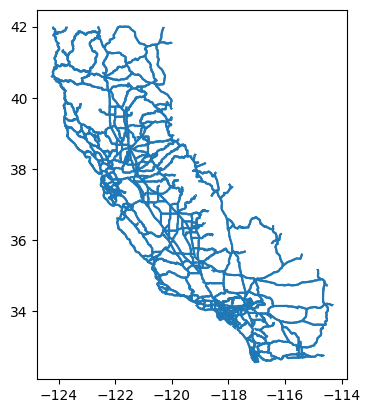

In [7]:
highways.plot()

In [8]:
# This is still a gdf, just with 1 column
type(interstates)

geopandas.geodataframe.GeoDataFrame

In [9]:
df_check(interstates)

'shape of df:(1, 1)'

"type of :<class 'geopandas.geodataframe.GeoDataFrame'>"

,geometry
0,"MULTILINESTRING ((-122.06017 39.01932, -122.06..."


In [10]:
# Pulling out the individual column, it becomes a series/geoseries.
# It's a geoseries here because we had a gdf. 
# If it was a df, it would be a series.
print(type(stops.geometry))
print(type(interstates.geometry))

<class 'geopandas.geoseries.GeoSeries'>
<class 'geopandas.geoseries.GeoSeries'>


Distance is something you can calculate using `geopandas`.

Specifically, it takes a geoseries on the left, and either a geoseries or a single geometry on the right.

An example of having 2 geoseries would be comparing the distance between 2 points. On the left, it would be a geoseries of the origin points and on the right, destination points.

In [11]:
# We get a warning if we leave it in EPSG:4326!
stops.geometry.distance(interstates.geometry.iloc[0])

/tmp/ipykernel_288/2451250416.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  stops.geometry.distance(interstates.geometry.iloc[0])


0         0.023029
1         0.024552
2         0.027300
3         0.026145
4         0.023530
            ...   
119963    0.294958
119964    0.293110
119965    0.292390
119966    0.293875
119967    0.291830
Length: 119968, dtype: float64

In [12]:
stops_geom = stops.to_crs("EPSG:2229").geometry
interstates_geom = interstates.to_crs("EPSG:2229").geometry.iloc[0]

In [13]:
df_check(stops_geom)

'shape of df:(119968,)'

"type of :<class 'geopandas.geoseries.GeoSeries'>"

0    POINT (6524633.136 1856921.370)
1    POINT (6524314.055 1857471.449)
2    POINT (6523735.660 1858464.463)
3    POINT (6522841.383 1858033.829)
4    POINT (6523201.162 1857086.299)
Name: geometry, dtype: geometry

In [14]:
interstates_geom

In [15]:
distance_series = stops_geom.distance(interstates_geom)

In [16]:
#returns a series (like a 1 col table)
df_check(distance_series)


'shape of df:(119968,)'

"type of :<class 'pandas.core.series.Series'>"

0    8380.457848
1    8934.678733
2    9934.870517
3    9514.343662
4    8562.818602
dtype: float64

In [17]:
# Let's make sure that for every stop, a distance is calculated
print(f"# rows in stops: {len(stops_geom)}")
print(f"# rows in stops: {len(distance_series)}")

# rows in stops: 119968
# rows in stops: 119968


In [18]:
# distance is numeric, not a geometry, so we're back to being a series
type(distance_series)

pandas.core.series.Series

What can we do with this? 

We usually add it as a new column. Since we did nothing to shift the index, we can just attach the series back to our gdf.

Getting a distance calculation using geoseries is much quicker than a row-wise lambda function where you calculate the distance.

```
Alternative method that's slower:
      
interstate_geom = interstates.geometry.iloc[0]

stops = stops.assign(
   distance = stops.geometry.apply(
         lambda x: x.distance(interstate_geom))
)   
```

In [19]:
#adds a new column to stops called `distance_to_interstate` and fills it with values from `distance_series`. 
#the indicies are the same for both, meaning they match up

stops = stops.assign(
    distance_to_interstate = distance_series
)

In [20]:
df_check(stops)

'shape of df:(119968, 5)'

"type of :<class 'geopandas.geodataframe.GeoDataFrame'>"

,agency,stop_id,stop_name,geometry,distance_to_interstate
0,City of Alhambra,2619798,Chapel Ave & Bay St,POINT (-118.12232 34.09485),8380.457848
1,City of Alhambra,2619799,Chapel Ave & Main St,POINT (-118.12338 34.09636),8934.678733
2,City of Alhambra,2619802,Chapel Ave & Woodward Ave,POINT (-118.12529 34.09908),9934.870517
3,City of Alhambra,2619804,Woodward Ave & Garfield Ave,POINT (-118.12824 34.09790),9514.343662
4,City of Alhambra,2619807,Garfield Ave & Main St,POINT (-118.12705 34.09530),8562.818602


In [22]:
#this cell took a loooooooong time to run
#%%timeit
#distance_series = stops_geom.distance(interstates_geom)

In [23]:
#also took a loooooong time to run
#%%timeit
#stops.assign(
   #distance = stops.geometry.apply(
       #  lambda x: x.distance(interstates_geom))
#)   

In [24]:
#import dask_geopandas as dg

#stops_gddf = dg.from_geopandas(stops, npartitions=2)
#stops_geom_dg = stops_gddf.to_crs("EPSG:2229").geometry

In [25]:
#was a lot laster to run
#%%timeit

#distance_series = stops_geom_dg.distance(interstates_geom)

## To Do

* Use the `stop_times` table and `stops` table.
* Calculate the straight line distance between the first and last stop for each trip. Call this column `trip_distance`
* Calculate the distance between each stop to the nearest interstate. For each trip, keep the value for the stop that's the closest to the interstate. Call this column `shortest_distance_hwy`.
* For each trip, add these 2 new columns, but use series, geoseries, and/or arrays to assign it.
* Provide a preview of the resulting df (do not export)

In [26]:
GCS_FILE_PATH = ("gs://calitp-analytics-data/data-analyses/"
                 "rt_delay/compiled_cached_views/"
                )

analysis_date = "2023-01-18"
STOP_TIMES_FILE = f"{GCS_FILE_PATH}st_{analysis_date}.parquet"
STOPS_FILE = f"{GCS_FILE_PATH}stops_{analysis_date}.parquet"
highways = catalog.state_highway_network.read()

In [27]:
#test to import parquet files
stops = pd.read_parquet(STOPS_FILE)
stop_times = pd.read_parquet(STOP_TIMES_FILE)

/opt/conda/lib/python3.9/site-packages/google/auth/_default.py:78: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [28]:
#what does each row mean?
#each row is a stop_key, a stop_key can have multiple feeds and stops
#what is the difference between stop_key and stop_id?

#noticed the geometry col is in WKB. need to convert this to something else.

df_check(stops)

'shape of df:(84688, 16)'

"type of :<class 'pandas.core.frame.DataFrame'>"

,feed_key,stop_id,stop_key,stop_name,route_type_0,route_type_1,route_type_2,route_type_3,route_type_4,route_type_5,route_type_6,route_type_7,route_type_11,route_type_12,missing_route_type,geometry
0,6adf6cd9b6d24ab4ee8ee220e3697a73,15193,d4eb0920e7e256606df449c31b3c3e6a,Vanowen / Encino,NaN,NaN,NaN,69.0,NaN,NaN,None,None,None,None,None,"b'\x01\x01\x00\x00\x00?\xe5\x98,\xee\xa0]\xc0\..."
1,6adf6cd9b6d24ab4ee8ee220e3697a73,14025,038cca58ef5f071ff5c94b8213989f87,Vermont / 110th,NaN,NaN,NaN,107.0,NaN,NaN,None,None,None,None,None,b'\x01\x01\x00\x00\x00\x10\x1em\x1c\xb1\x92]\x...
2,6adf6cd9b6d24ab4ee8ee220e3697a73,15638,06b1447efcc028791c8409d65fa3b3ee,3rd / Hobart,NaN,NaN,NaN,143.0,NaN,NaN,None,None,None,None,None,b'\x01\x01\x00\x00\x00\xd7d\x8dz\x88\x93]\xc03...
3,6adf6cd9b6d24ab4ee8ee220e3697a73,10244,87f19e30889f90d25e6dee49f04c4985,Vernon / Hooper,NaN,NaN,NaN,97.0,NaN,NaN,None,None,None,None,None,b'\x01\x01\x00\x00\x00z\xc2\x12\x0f(\x90]\xc0\...
4,6adf6cd9b6d24ab4ee8ee220e3697a73,20206,eda9e3eb339b7f510babcd4ee0999f85,Broadway / Pacific,NaN,NaN,NaN,108.0,NaN,NaN,None,None,None,None,None,b'\x01\x01\x00\x00\x001du\xab\xe7\x90]\xc0\xf4...


In [29]:
#found method to create geoseries from wkb.
test = gpd.GeoSeries.from_wkb(stops.geometry)


In [30]:
#have a geoeries called `test`. now i am able to add this series back to initial stops table (using assign)
#stops = stops.assign(
#    distance_to_interstate = distance_series
#)
stops2 = stops.assign(wkb_to_pt = test)

In [31]:
#now I can create a gdf and set an active geom col and change crs to ft.

stops2 = gpd.GeoDataFrame(stops2).set_geometry('wkb_to_pt').set_crs('EPSG:2229')

'shape of df:(84688, 17)'

"type of :<class 'geopandas.geodataframe.GeoDataFrame'>"

,feed_key,stop_id,stop_key,stop_name,route_type_0,route_type_1,route_type_2,route_type_3,route_type_4,route_type_5,route_type_6,route_type_7,route_type_11,route_type_12,missing_route_type,geometry,wkb_to_pt
0,6adf6cd9b6d24ab4ee8ee220e3697a73,15193,d4eb0920e7e256606df449c31b3c3e6a,Vanowen / Encino,NaN,NaN,NaN,69.0,NaN,NaN,None,None,None,None,None,"b'\x01\x01\x00\x00\x00?\xe5\x98,\xee\xa0]\xc0\...",POINT (-118.515 34.194)
1,6adf6cd9b6d24ab4ee8ee220e3697a73,14025,038cca58ef5f071ff5c94b8213989f87,Vermont / 110th,NaN,NaN,NaN,107.0,NaN,NaN,None,None,None,None,None,b'\x01\x01\x00\x00\x00\x10\x1em\x1c\xb1\x92]\x...,POINT (-118.292 33.936)
2,6adf6cd9b6d24ab4ee8ee220e3697a73,15638,06b1447efcc028791c8409d65fa3b3ee,3rd / Hobart,NaN,NaN,NaN,143.0,NaN,NaN,None,None,None,None,None,b'\x01\x01\x00\x00\x00\xd7d\x8dz\x88\x93]\xc03...,POINT (-118.305 34.069)
3,6adf6cd9b6d24ab4ee8ee220e3697a73,10244,87f19e30889f90d25e6dee49f04c4985,Vernon / Hooper,NaN,NaN,NaN,97.0,NaN,NaN,None,None,None,None,None,b'\x01\x01\x00\x00\x00z\xc2\x12\x0f(\x90]\xc0\...,POINT (-118.252 34.004)
4,6adf6cd9b6d24ab4ee8ee220e3697a73,20206,eda9e3eb339b7f510babcd4ee0999f85,Broadway / Pacific,NaN,NaN,NaN,108.0,NaN,NaN,None,None,None,None,None,b'\x01\x01\x00\x00\x001du\xab\xe7\x90]\xc0\xf4...,POINT (-118.264 34.147)


<AxesSubplot:>

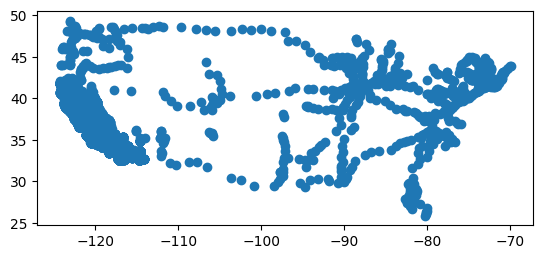

In [32]:
#function confirms that stops2 is a gdf, also used `stops2.geometry.name` and `stops2.crs` to confirm active geom col and crs was set as intended.
df_check(stops2)

#plotting reveals the stops2 is nationwide. will need to clip this to CA only or something.
stops2.plot()

In [33]:
df_check(stop_times)

'shape of df:(3589931, 9)'

"type of :<class 'pandas.core.frame.DataFrame'>"

,feed_key,trip_id,stop_id,stop_sequence,timepoint,arrival_sec,departure_sec,arrival_hour,departure_hour
0,48138ae7269d615d5509958097039bf7,t287-b194-sl4_merged_3564,1140,11,NaN,25047,25047,6,6
1,48138ae7269d615d5509958097039bf7,t708-b12D-sl4_merged_4213,1161,25,NaN,66583,66583,18,18
2,48138ae7269d615d5509958097039bf7,t476-b194-sl4_merged_4047,1153,22,NaN,43440,43440,12,12
3,48138ae7269d615d5509958097039bf7,t6DF-b68-sl4_merged_3187,1437,4,NaN,64959,64959,18,18
4,d4642902c43d526677dff02b09342b78,t607-b1F4B-sl2_merged_1620,601,1,NaN,56580,56580,15,15


In [34]:
#cleaned up a couple of columns, dissolved by routes, reset index and set crs to feet
highways_d = highways[['Route', 'geometry', 'RouteType']].dissolve(by='Route').reset_index().to_crs('EPSG:2229')

<AxesSubplot:>

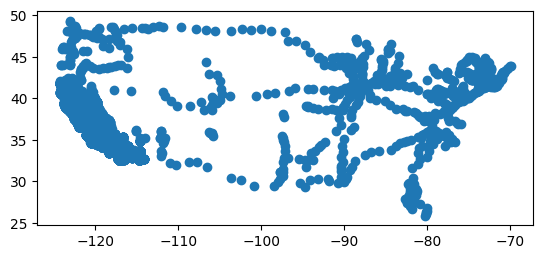

In [72]:
#can you sjoin highways and stops to get stops in ca?

sjoin = gpd.sjoin(highways.to_crs('EPSG:2229'), stops2, how='right')
sjoin.plot()

'shape of df:(242, 3)'

"type of :<class 'geopandas.geodataframe.GeoDataFrame'>"

,Route,geometry,RouteType
0,1,"MULTILINESTRING ((6518147.781 1746024.206, 651...",State
1,2,"MULTILINESTRING ((6490992.937 1865622.285, 649...",State
2,3,"MULTILINESTRING ((5275615.149 4654447.197, 527...",State
3,4,"MULTILINESTRING ((5983573.255 3460229.889, 598...",State
4,5,"MULTILINESTRING ((5405204.172 3674443.942, 540...",Interstate


<AxesSubplot:>

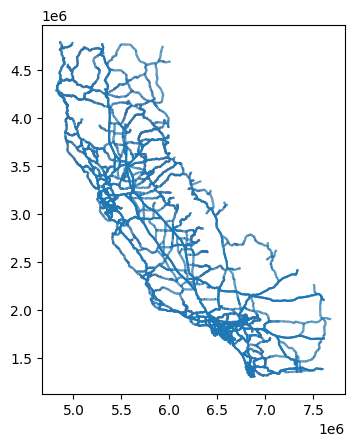

In [35]:
df_check(highways_d)
highways_d.plot()

In [36]:
#dissolve highways_d again to get single CA polygon? idk lets try anyways and test to see if we can clip it
ca = highways_d.dissolve()
ca.crs

<Projected CRS: EPSG:2229>
Name: NAD83 / California zone 5 (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - California - counties Kern; Los Angeles; San Bernardino; San Luis Obispo; Santa Barbara; Ventura.
- bounds: (-121.42, 32.76, -114.12, 35.81)
Coordinate Operation:
- name: SPCS83 California zone 5 (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [37]:
#Calculate the straight line distance between the first and last stop for each trip. Call this column trip_distance

#how do find the first and last stop of a trip? try a grouby/agg 

In [38]:
stop2times = stops2.merge(stop_times, how='inner', on=['feed_key', 'stop_id'])

In [39]:
df_check(stop2times)

'shape of df:(3589718, 24)'

"type of :<class 'geopandas.geodataframe.GeoDataFrame'>"

,feed_key,stop_id,stop_key,stop_name,route_type_0,route_type_1,route_type_2,route_type_3,route_type_4,route_type_5,...,missing_route_type,geometry,wkb_to_pt,trip_id,stop_sequence,timepoint,arrival_sec,departure_sec,arrival_hour,departure_hour
0,6adf6cd9b6d24ab4ee8ee220e3697a73,15193,d4eb0920e7e256606df449c31b3c3e6a,Vanowen / Encino,NaN,NaN,NaN,69.0,NaN,NaN,...,None,"b'\x01\x01\x00\x00\x00?\xe5\x98,\xee\xa0]\xc0\...",POINT (-118.515 34.194),10165002071128-DEC22,54,0.0,44760,44760,12,12
1,6adf6cd9b6d24ab4ee8ee220e3697a73,15193,d4eb0920e7e256606df449c31b3c3e6a,Vanowen / Encino,NaN,NaN,NaN,69.0,NaN,NaN,...,None,"b'\x01\x01\x00\x00\x00?\xe5\x98,\xee\xa0]\xc0\...",POINT (-118.515 34.194),10165002070728-DEC22,54,0.0,30480,30480,8,8
2,6adf6cd9b6d24ab4ee8ee220e3697a73,15193,d4eb0920e7e256606df449c31b3c3e6a,Vanowen / Encino,NaN,NaN,NaN,69.0,NaN,NaN,...,None,"b'\x01\x01\x00\x00\x00?\xe5\x98,\xee\xa0]\xc0\...",POINT (-118.515 34.194),10165002071426-DEC22,54,0.0,55740,55740,15,15
3,6adf6cd9b6d24ab4ee8ee220e3697a73,15193,d4eb0920e7e256606df449c31b3c3e6a,Vanowen / Encino,NaN,NaN,NaN,69.0,NaN,NaN,...,None,"b'\x01\x01\x00\x00\x00?\xe5\x98,\xee\xa0]\xc0\...",POINT (-118.515 34.194),10165002071113-DEC22,54,0.0,43860,43860,12,12
4,6adf6cd9b6d24ab4ee8ee220e3697a73,15193,d4eb0920e7e256606df449c31b3c3e6a,Vanowen / Encino,NaN,NaN,NaN,69.0,NaN,NaN,...,None,"b'\x01\x01\x00\x00\x00?\xe5\x98,\xee\xa0]\xc0\...",POINT (-118.515 34.194),10165002071541-DEC22,54,0.0,60180,60180,16,16


In [57]:
#test to find the first stop of a trip usign .iloc[0]
group = stop_times.groupby('trip_id')

In [58]:
first_stop = []
last_stop = []

In [59]:
# FOR LOOPS!!!
#for `every trip_id` group in group df, do this operation
for trip_id, group in group:
    f_stop = group.iloc[0]['stop_id']
    l_stop = group.iloc[-1]['stop_id']

In [60]:
first_stop.append(f_stop)
first_stop

['1']

In [61]:
last_stop.append(l_stop)
last_stop

['11']

In [63]:
group.groups.keys()

AttributeError: 'DataFrame' object has no attribute 'groups'

In [62]:
test = stop2times({'trip_id': group.groups.keys(), 
                   'first_stop': first_stop, 
                   'last_stop': last_stop}
                 )
test.head

AttributeError: 'DataFrame' object has no attribute 'groups'

In [ ]:

#add new col - first_stop. use assign with trip ID, and stop_sequence.iloc[0]
#add new col - last _stop. use assign with trip ID, and stop_sequence.iloc[-1]
#all new col - distance between first and last stop with distance first stop, last stop



# hall-o-shame

In [ ]:
#overlay highways with stops2?
#RETURNS NOTHING!
#test = gpd.overlay(stops2, highways.to_crs('EPSG:2229'), how='intersection', keep_geom_type=True)

In [ ]:
#try to overlay stop2times on highways_d (points on line?)
#RETURNS NOTHING!
#test = gpd.overlay(highways.to_crs('EPSG:2229'), stop2times, how ='intersection', keep_geom_type=True)

In [ ]:
#df_check(test)

In [ ]:
#Calculate the distance between each stop to the nearest interstate. 
#For each trip, keep the value for the stop that's the closest to the interstate. Call this column shortest_distance_hwy.

In [ ]:
#can i dissolve by trip_ID, then get length?

#NOPE DIDNT WORK AS EXPECTED

#trip_d = stop2times.dissolve(by='trip_id').reset_index()

In [ ]:
#df_check(trip_d)
#trip_d.plot()